# scRNAseq analysis

- https://support.10xgenomics.com/single-cell-gene-expression/software/pipelines/latest/what-is-cell-ranger
- cellranger `count`: Counts cell barcodes, aligns to genome/transcriptome, counts UMIs


Example invocation:

```
$ cellranger count --id=sample345 \
                   --transcriptome=/opt/refdata-gex-GRCh38-2020-A \
                   --fastqs=/home/jdoe/runs/HAWT7ADXX/outs/fastq_path \
                   --sample=mysample \
                   --expect-cells=1000 \
                   --localcores=8 \
                   --localmem=64
```

Example output:

```
Outputs:
- Run summary HTML:                         /opt/sample345/outs/web_summary.html
- Run summary CSV:                          /opt/sample345/outs/metrics_summary.csv
- BAM:                                      /opt/sample345/outs/possorted_genome_bam.bam
- BAM index:                                /opt/sample345/outs/possorted_genome_bam.bam.bai
- Filtered feature-barcode matrices MEX:    /opt/sample345/outs/filtered_feature_bc_matrix
- Filtered feature-barcode matrices HDF5:   /opt/sample345/outs/filtered_feature_bc_matrix.h5
- Unfiltered feature-barcode matrices MEX:  /opt/sample345/outs/raw_feature_bc_matrix
- Unfiltered feature-barcode matrices HDF5: /opt/sample345/outs/raw_feature_bc_matrix.h5
- Secondary analysis output CSV:            /opt/sample345/outs/analysis
- Per-molecule read information:            /opt/sample345/outs/molecule_info.h5
- CRISPR-specific analysis:                 null
- Loupe Browser file:                       /opt/sample345/outs/cloupe.cloupe
- Feature Reference:                        null
- Target Panel File:                        null

Waiting 6 seconds for UI to do final refresh.
Pipestance completed successfully!

yyyy-mm-dd hh:mm:ss Shutting down.
Saving pipestance info to "tiny/tiny.mri.tgz"
```

What is actually doing?

- Trims reads
- Splicing aware alignment to reference genome
- GTF file to assign aligned reads to transcripts (see below)
- handles reads mapping to >1 locus

How does it handle reads that hit different parts of the genome?


<img src="img/gex-processing-introns.png">

- aligned reads for UMI counting, by default, are ' transcriptomic' (blue) reads
- Often useful an more appropriate to include exonic and intronic aligned reads, too
- `include-introns`: use all but antisense reads for UMI counting

##### UMI counting:
    
- group reads with same cell bc, umi, gene
- correct umis (one base off)
- cell bc, umi, diff gene -> only keep gene with most support
- discard both if tied
- all reads with same cell bc, umi, gene are counted as one UMI
- number of reads contributing to that UMI are stored in molecule info file (useful later)


##### Detecting cells

- EmptyDrops method (Lun et al 2018)
- ID true positives with total UMI threshold determine based on total UMIs in top fraction of expected numvber of barcodes
- Select set of true negatives and compare complexity of remaining barcodes to it


<img src="img/knee-plot-old-cell-calling.png">

<img src="img/knee-plot-new-cell-calling.png">

#### CellRanger output status (web summary)

<img src="img/web-summary-gex-3.1a.png">

##### Sequencing saturation: 

- "If sequencing saturation is at 50%, it means that every 2 new reads will result in 1 new UMI count (unique transcript) detected."
- Calcualted based on the ratio of unique to duplicate UMIs

<hr>


#### Post UMI counting analysis

- Loading data
- Standard quality control
- Some fun, downstream stuff

Scanpy https://scanpy.readthedocs.io/en/stable/# is the package that will be the workhorse for much of what we do in the class,



In [ ]:
%pip install scanpy

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import scipy as sp
import numpy as np

You can download the data used below from <a href="https://compstemcellbio.s3.amazonaws.com/2022/data/d4_scRNAseq_data.zip">here</a>. It is a zip file containing the market matrix files that I showed you in class: genes.tsv, matrix.mtx, and barcodes.tsv. You will need to unzip it, and then change the path argument below so that it is pointing to wherever you unzipped the 3 files.

In [2]:
adata = sc.read_10x_mtx("data/d4/", var_names='gene_symbols',cache=True, gex_only=True)

In [3]:
adata

AnnData object with n_obs × n_vars = 5405 × 27998
    var: 'gene_ids'

What is an anndata?

<img src="img/anndata.png">

In [4]:
adata.obs

""
AAACATACCCTACC-1
AAACATACGTCGTA-1
AAACATACTTTCAC-1
AAACATTGCATTGG-1
AAACATTGCTTGCC-1
...
TTTGACTGAGGCGA-1
TTTGACTGCATTGG-1
TTTGACTGCTGGAT-1
TTTGACTGGTGAGG-1


In [6]:
adata.obs_names

Index(['AAACATACCCTACC-1', 'AAACATACGTCGTA-1', 'AAACATACTTTCAC-1',
       'AAACATTGCATTGG-1', 'AAACATTGCTTGCC-1', 'AAACATTGGACGAG-1',
       'AAACATTGGGTCTA-1', 'AAACATTGTGACCA-1', 'AAACCGTGAAAGCA-1',
       'AAACCGTGAACGTC-1',
       ...
       'TTTCTACTGACAAA-1', 'TTTCTACTGCGGAA-1', 'TTTCTACTTGCATG-1',
       'TTTCTACTTGGTAC-1', 'TTTGACTGACTCTT-1', 'TTTGACTGAGGCGA-1',
       'TTTGACTGCATTGG-1', 'TTTGACTGCTGGAT-1', 'TTTGACTGGTGAGG-1',
       'TTTGACTGTACAGC-1'],
      dtype='object', length=5405)

In [7]:
adata.var

,gene_ids
Xkr4,ENSMUSG00000051951
Gm1992,ENSMUSG00000089699
Gm37381,ENSMUSG00000102343
Rp1,ENSMUSG00000025900
Rp1-1,ENSMUSG00000109048
...,...
AC168977.1,ENSMUSG00000079808
PISD,ENSMUSG00000095041
DHRSX,ENSMUSG00000063897
Vmn2r122,ENSMUSG00000096730


In [8]:
adata.var_names

Index(['Xkr4', 'Gm1992', 'Gm37381', 'Rp1', 'Rp1-1', 'Sox17', 'Gm37323',
       'Mrpl15', 'Lypla1', 'Gm37988',
       ...
       'AC125149.1', 'AC125149.2', 'AC125149.4', 'AC234645.1', 'AC168977.2',
       'AC168977.1', 'PISD', 'DHRSX', 'Vmn2r122', 'CAAA01147332.1'],
      dtype='object', length=27998)

We can add to obs. For example, I want to add some sample annotation

In [11]:
adata.obs['sampleName'] = "mEB_day4"

Let's look at how the plotting functions work. 

Note that, in general, scanpy has 3 classes of functions:

sc.pp: pre-processing functions
sc.tl: tools
sc.pl: plotting

In the example below, the function `highest_expr_genes` identifies the n_top genes with highest mean expression, and then passes the expression of these on to sns.boxplot function:

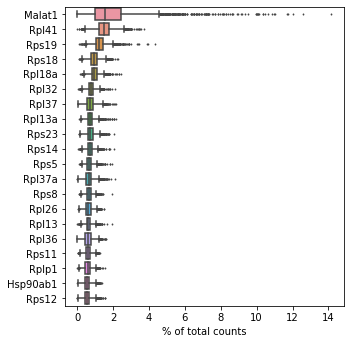

In [9]:
sc.pl.highest_expr_genes(adata, n_top=20, )

You can use the \*\*kwrds feature to pass arguments directly through to sns.boxplot as name=value pairs. Here, we set palette and width args:

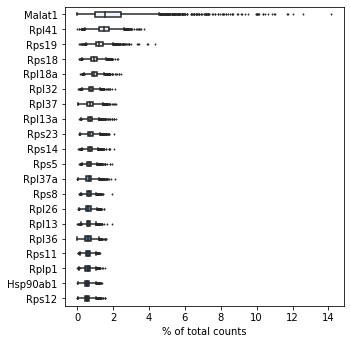

In [12]:
sc.pl.highest_expr_genes(adata, n_top=20, palette="Blues", width=.3)

We can alter some of the default plotting parameters, too, like the resolution 

In [13]:
sc.settings.set_figure_params(dpi=80)

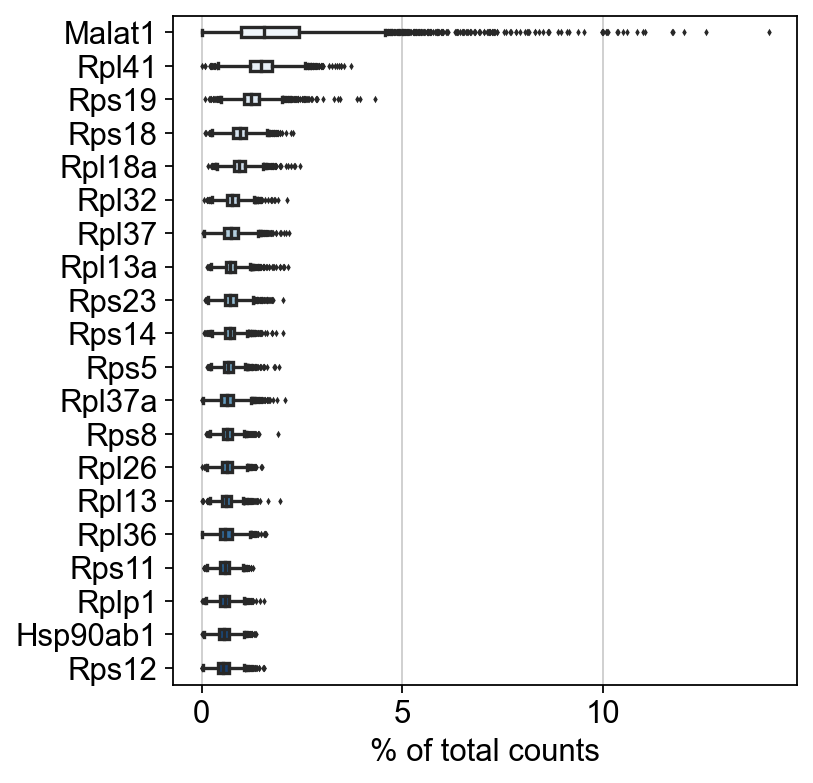

In [14]:
sc.pl.highest_expr_genes(adata, n_top=20, palette="Blues", width=.3)

It is commonplace to calculate the percent of reads that come from mitocondrially-encoded genes and ribosomal genes. ** NB ** In lecture I said that the ribosomal genes shown above are not poly-adenylated. This was incorrect. These transcripts **are** polyadenylated. Thank you to the student who pointed this out after class!

The reasons that we like to calculate these values is as follows:

- mt genes are thought to be relatively more persistent in dying or damaged cells.
- ribosomal genes are highly abundant. Thus barcodes in which ribosomal genes make up the vast proportion of UMIs might yield low sensitivity for all other transcripts. 

We can readily find both classes genes based on their symbols. Let's add this to .var:

In [15]:
adata.var['mt']= adata.var_names.str.startswith(("mt-"))
print(sum(adata.var['mt']))

13


In [16]:
adata.var['ribo'] = adata.var_names.str.startswith(("Rps","Rpl"))
print(sum(adata.var['ribo']))

113


In [17]:
adata.var

,gene_ids,mt,ribo
Xkr4,ENSMUSG00000051951,False,False
Gm1992,ENSMUSG00000089699,False,False
Gm37381,ENSMUSG00000102343,False,False
Rp1,ENSMUSG00000025900,False,False
Rp1-1,ENSMUSG00000109048,False,False
...,...,...,...
AC168977.1,ENSMUSG00000079808,False,False
PISD,ENSMUSG00000095041,False,False
DHRSX,ENSMUSG00000063897,False,False
Vmn2r122,ENSMUSG00000096730,False,False


`sc.pp.calculate_qc_metrics` calculates the specified quantities (and several others by default) and adds them to the .obs data frame

In [18]:
sc.pp.calculate_qc_metrics(adata, qc_vars=['ribo', 'mt'], percent_top=None, log1p=False, inplace=True)

In [19]:
adata.obs

,sampleName,n_genes_by_counts,total_counts,total_counts_ribo,pct_counts_ribo,total_counts_mt,pct_counts_mt
AAACATACCCTACC-1,mEB_day4,1212,2238.0,629.0,28.105453,28.0,1.251117
AAACATACGTCGTA-1,mEB_day4,1588,3831.0,1267.0,33.072304,34.0,0.887497
AAACATACTTTCAC-1,mEB_day4,1538,3381.0,961.0,28.423544,2.0,0.059154
AAACATTGCATTGG-1,mEB_day4,1221,2489.0,750.0,30.132584,24.0,0.964243
AAACATTGCTTGCC-1,mEB_day4,2661,9510.0,3132.0,32.933754,71.0,0.746583
...,...,...,...,...,...,...,...
TTTGACTGAGGCGA-1,mEB_day4,2446,6908.0,1999.0,28.937466,65.0,0.940938
TTTGACTGCATTGG-1,mEB_day4,2906,9558.0,3067.0,32.088303,91.0,0.952082
TTTGACTGCTGGAT-1,mEB_day4,1475,3280.0,1035.0,31.554878,22.0,0.670732
TTTGACTGGTGAGG-1,mEB_day4,2808,9123.0,2923.0,32.039898,55.0,0.602872


Now let's vizualize this using a multi-panel violin plot

/usr/local/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'sampleName' as categorical


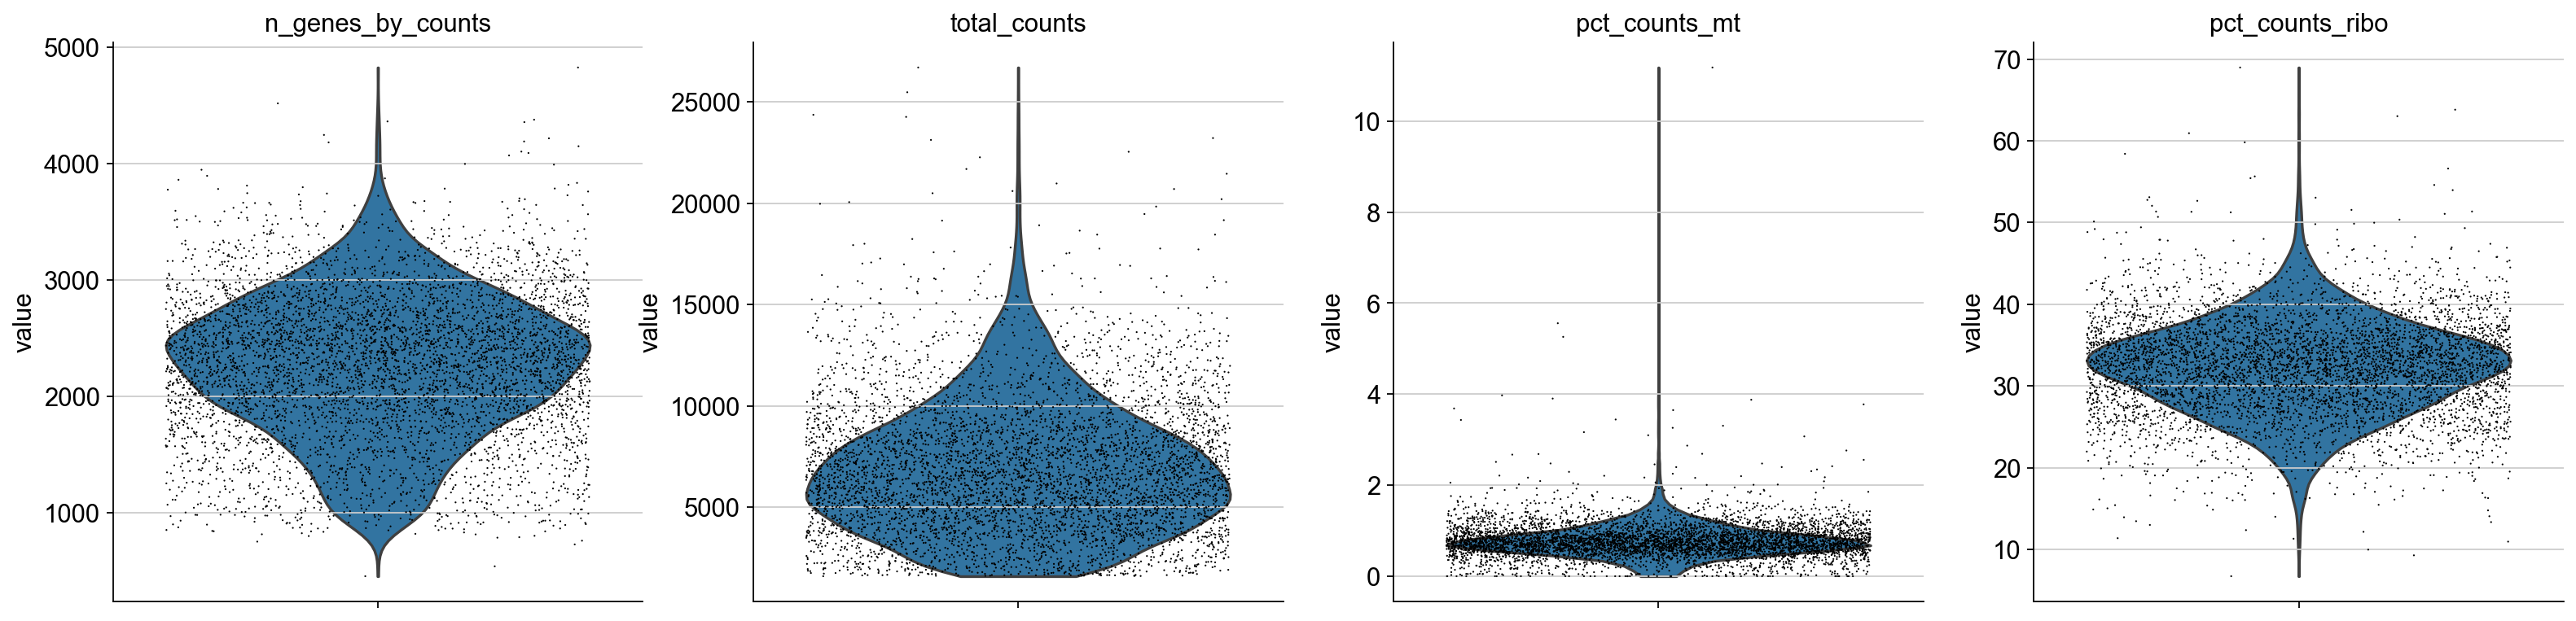

In [20]:
axs = sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt', 'pct_counts_ribo'],jitter=0.4, multi_panel=True)

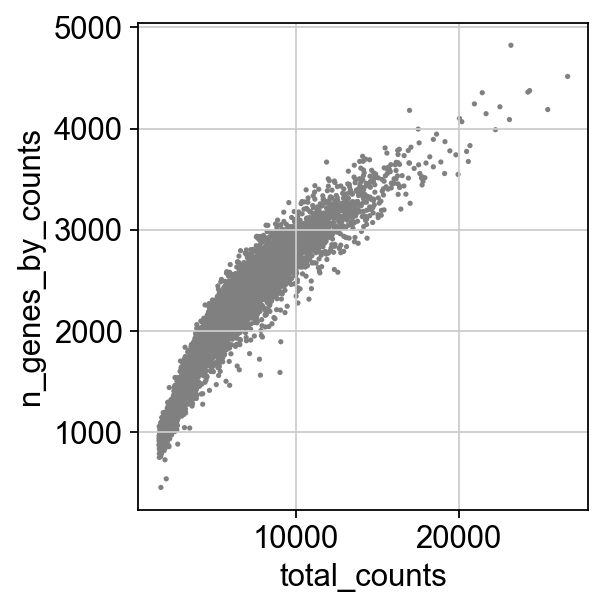

In [ ]:
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

Finally, let's filter some of these barcodes out based on total_counts, to exclude possible doublets, and to remove "low quality" cells based on a mt and ribo count:

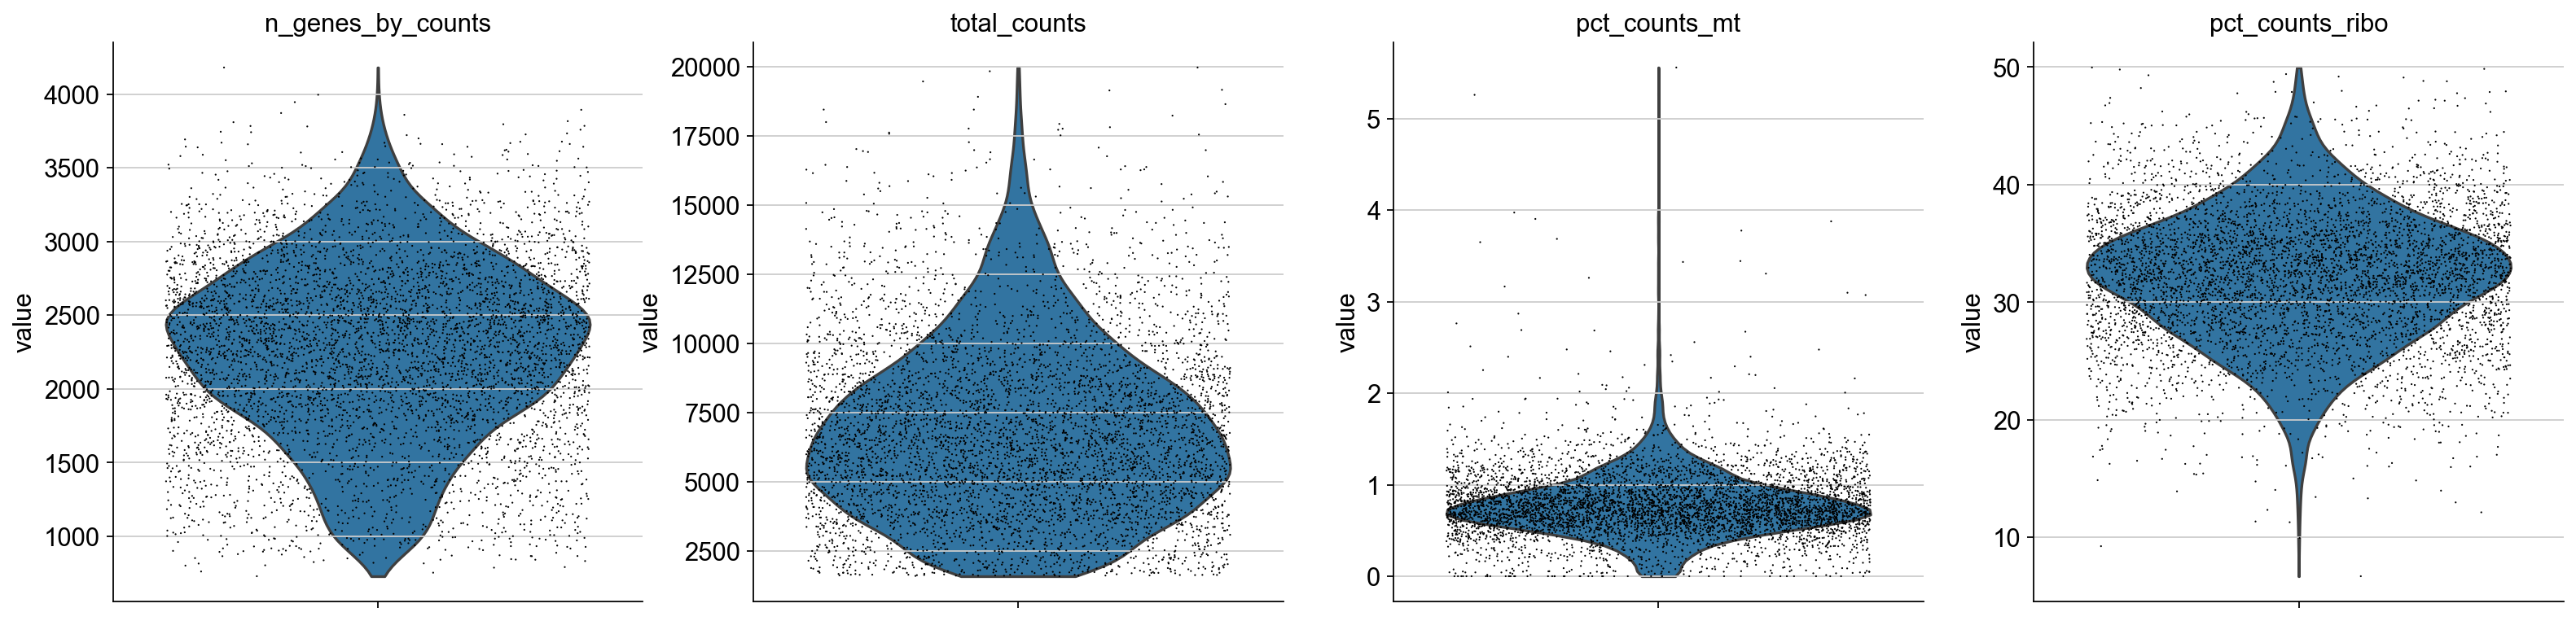

In [ ]:
adata = adata[adata.obs['total_counts'] < 20000, :]
adata = adata[adata.obs['pct_counts_mt'] < 10, :]
# filter for percent ribo > 0.05
adata = adata[adata.obs['pct_counts_ribo'] < 50, :]
axs = sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt', 'pct_counts_ribo'],jitter=0.4, multi_panel=True)

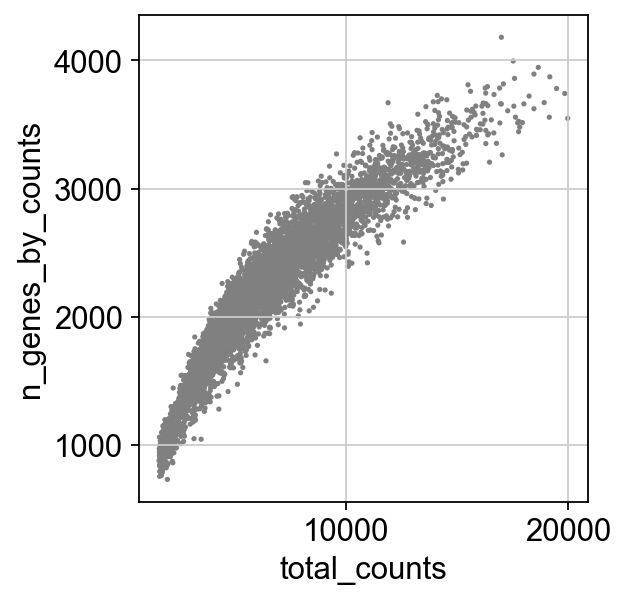

In [ ]:
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

This is where we finished class. We will pick up here on Tuesday